Check fixed points

In [1]:
# System
import logging
import time
import os
import pickle
# Math
import math
import scipy as sp
import numpy as np
import scipy.linalg as lin
import scipy.optimize as opt
import pandas as pd
# Visualization
%matplotlib inline 
import matplotlib.pyplot as plt
# Various
# My packages
import carpet
from carpet import rms, circ_dist, order_parameter # root mean square
import carpet.visualize as vis
import carpet.lattice.triangular as lattice
import carpet.physics.friction_pairwise as physics

import carpet.classes as cc
import carpet.parallel_with_threads as pwt # to find fixpoints faster

In [2]:
import logging
import os

shortname = '.' # RENAME THIS FOR A NEW NOTEBOOK
objfolder = '.'
## Setup logging


def dump_object(obj, filename, path=objfolder):
    filename = os.path.join(path, filename)
    print(filename)
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_object(filename, path=objfolder):
    filename = os.path.join(path, filename)
    with open(filename, 'rb') as f:
        obj = pickle.load(f)      
    return obj

In [3]:
# Physics
set_name = 'machemer_1' # which hydrodynamic coefficients to use
order_g11 = (8,0)
order_g12 = (4,4)
period = 31.25            # [ms] period of cilia beat
freq = 2 * np.pi / period # [rad/ms] angular frequency

# Geometry
nx = 6
ny = 6  # even number
N = nx * ny
a = 18  # [um] lattice spacing

## Initialize
# Geometry

L1,L2 = lattice.get_domain_sizes(nx,ny ,a)
coords, lattice_ids = lattice.get_nodes_and_ids(nx, ny, a)  # get cilia (nodes) coordinates

distances = [1]
NN, TT = lattice.get_neighbours_list(coords, nx, ny, a, distances)
e1, e2 = lattice.get_basis()
get_k = lattice.define_get_k(nx, ny, a)
get_mtwist = lattice.define_get_mtwist(coords, nx, ny, a)

# Physics
gmat_glob, q_glob = physics.define_gmat_glob_and_q_glob(set_name, e1, e2, a, NN, TT, order_g11, order_g12, period,
                                                        use_numba=False)
right_side_of_ODE = physics.define_right_side_of_ODE(gmat_glob, q_glob)
solve_cycle = carpet.define_solve_cycle(right_side_of_ODE, 2 * period, phi_global_func=carpet.get_mean_phase)

# Define solve_cycle assuming symmetry classes - used to find fixed points faster.
def define_solve_cycle_class(NN_class, TT_class):
    gmat_glob_class, q_glob_class = physics.define_gmat_glob_and_q_glob(set_name, e1, e2, a, NN_class, TT_class,
                                                                        order_g11, order_g12, period, use_numba=False)
    right_side_of_ODE_class = physics.define_right_side_of_ODE(gmat_glob_class, q_glob_class)
    return     carpet.define_solve_cycle(right_side_of_ODE_class, 2 * period,
                              phi_global_func=carpet.get_mean_phase)

In [4]:
# Merge
# ## Combine results
fixpoint_dict = {} # Dictionary with eigenvalues, corresponding to each of m-twists
script_path = '.' # 

for k1,k2 in [(k1,k2) for k1 in range(nx) for k2 in range(ny)]:
    filename = "fixpoint_k1={}_k2={}.pkl".format(k1,k2)
    fixpoint = load_object(filename, script_path)
    fixpoint_dict[k1,k2] = fixpoint

tol = 10 ** -8
filename = 'fixpoint_dict_nx={}_ny={}_tol={:.3E}.pkl'.format(nx,ny,tol)
dump_object(fixpoint_dict, filename)

.\fixpoint_dict_nx=6_ny=6_tol=1.000E-08.pkl


In [5]:
# # Load fixpoints
# tol = 10 ** -8
# filename = 'fixpoint_dict_class_finer.pkl' #'fixpoint_dict_nx={}_ny={}_tol={:.3E}.pkl'.format(nx,ny,tol)
# path = 'out/08/'

# fixpoint_dict = load_object(filename,path)


def get_fixpoint(k1,k2):
    return np.array(fixpoint_dict[k1,k2])

In [6]:
# Check mean phase
# Result: non-zero
for k1 in range(nx):
    for k2 in range(ny):
        fixpoint = get_fixpoint(k1,k2)
        diff = carpet.get_mean_phase(fixpoint)
        if abs(diff) > 10 ** -6:
            print(k1,k2, diff)

In [7]:
# Check for phase slips
for k1 in range(nx):
    for k2 in range(ny):
        flag = False
        fixpoint = get_fixpoint(k1,k2)
        for phii in fixpoint:
            if abs(phii) >  np.pi: # 2 *
                flag = True            
        if flag == True:
            print(k1,k2, True)
print("Printed wave modes where phase slips occured in the procedure. Others - OK")

Printed wave modes where phase slips occured in the procedure. Others - OK


In [8]:
tol_extra = 10 ** -10

k1s = range(nx)
k2s = range(ny)
diffs = []
for k1 in k1s:
    for k2 in k2s:
        fp = get_fixpoint(k1,k2)
        sol = solve_cycle(fp, tol_extra)
        fp_image = sol.y.T[-1]
        diff = carpet.rms(fp - fp_image + 2 * np.pi)
        diffs.append(diff)

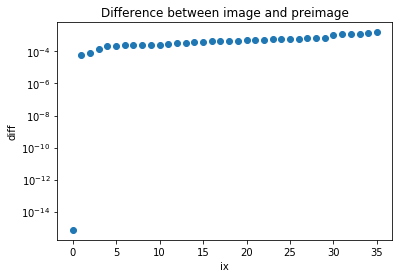

In [9]:
plt.plot(range(N), sorted(diffs), 'o', label='k1={}'.format(k1))
plt.title("Difference between image and preimage")
plt.yscale('log')
plt.xlabel('ix')
plt.ylabel('diff')
plt.show()

Fixed points are OK